# Homework 1
## Mert Yuksekgonul - 2016402147
## This is the summary of the results along with the required analysis. Some of the hyperparameters were chosen from the hyperparameter optimization that can be seen in HW1-Hyperparameter Experiments.ipynb

In [0]:
from keras import models
from keras import layers, regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding, Flatten
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import numpy as np
from pandas import read_csv
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import ParameterGrid
from keras import regularizers
from keras import backend as K
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

## General Purpose Functions <br>
### Train Function:
This function takes various parameters to handle the training phase for the experiments. It has several options for pre-processing, for different use cases.

In [0]:
def train(data, labels, folds, model_fn=None, model_params=dict(),
          preprocess="CountVector", convert_categorical=False, callbacks=None, batch_size=32, max_epochs=10, verbose=1):
  """ This function will be used to train a model with K-Fold cross validation, with given folds and data."""
  hist_list = []
  scores = []
  if convert_categorical:
    n_classes = max(labels)+1
    labels = to_categorical(labels, max(labels)+1)
    
  if preprocess=="Tokenizer":
    tokenizer = Tokenizer(num_words=10000)
    data = tokenizer.sequences_to_matrix(data, mode='binary')  
    
  elif preprocess=="Tokenizer_Sentence":
    tokenizer = Tokenizer(num_words=10000)
    tokenizer.fit_on_texts(data)
    data = tokenizer.texts_to_sequences(data)
    data = pad_sequences(data, maxlen=100)

  for i, (train_idx, val_idx) in enumerate(folds):
    x_train = np.array(data)[train_idx]
    y_train = labels[train_idx]
    x_val = np.array(data)[val_idx]
    y_val = labels[val_idx]
    
    if preprocess=="Normalize":
      mean = x_train.mean(axis=0)
      x_train -= mean
      std = x_train.std(axis=0)
      x_train /= std
      x_val -= mean
      x_val /= std
    
    elif preprocess=="CountVector":
      tokenizer = CountVectorizer()
      tokenizer.fit(x_train)
      x_val = tokenizer.transform(x_val).toarray()
      x_train = tokenizer.transform(x_train).toarray()
    
    model = model_fn(**model_params)
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=max_epochs, verbose=verbose, validation_data=(x_val, y_val))
    score = model.evaluate(x_val, y_val, verbose=0)
    hist_list.append(history)
    scores.append(score)
  print("Mean score: ",np.mean(np.array(scores)[:,1]))
  #print("1 5-fold training step completed.")
  return hist_list, scores
    

# Question 1

## 1.1 Loading Data

In [0]:
!wget -cq "https://archive.ics.uci.edu/ml/machine-learning-databases/00331/sentiment%20labelled%20sentences.zip" -O data.zip
!unzip data.zip
data = read_csv("./sentiment labelled sentences/imdb_labelled.txt", sep="\t", names=["sentence", "label"])
sentences = data.sentence.values
labels = data.label.values
folds = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=1997).split(sentences, labels))

max_words = 10000
max_input = 100
embedding_dim = 100

## 1.2 Model Function for Sentiment Analysis Experiments

In [0]:
def sentiment_model(n_layers=2, n_hidden=[32, 64], dropout=0.2, use_dropout=False, activation="relu", optimizer="adam", reg=None):
  if reg is None:
    regularizer = None
  elif reg=="l2":
    regularizer = regularizers.l2(0.01)
  elif reg=="l1":
    regularizer = regularizers.l1(0.01)
  model = Sequential()
  #model.add(Embedding(max_words, embedding_dim, input_length=max_input))
  #model.add(Flatten())
  model.add(Dense(n_hidden[0], kernel_regularizer=regularizer))
  model.add(Activation(activation))
  if use_dropout:
    model.add(Dropout(rate = dropout))
  for i in range(1,n_layers):
    model.add(Dense(n_hidden[i]))
    model.add(Activation(activation))
    if use_dropout:
      model.add(Dropout(rate = dropout))
  model.add(Dense(1))
  model.add(Activation("sigmoid"))
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model

## 1.3 Training Phase 

In [29]:
param_grid = {"n_layers":[2] ,"n_hidden":[[16,32]],
             "activation":["relu", "tanh"],"optimizer":["adam","rmsprop", "adagrad"]}

grid = ParameterGrid(param_grid)
best = -float("inf")
best_p = None
best_hist = None
all_scores = []
all_hists = dict()
all_hists["relu"] = dict()
all_hists["tanh"] = dict()

for params in grid:
  print("Params: ",params)
  hist, scores = train(sentences, labels, folds, sentiment_model, params,
                       "CountVector", False, None, verbose=0, max_epochs=30, batch_size=128)
  mean_ac = np.mean(np.array(scores)[:,1])
  all_scores.append(np.array(scores)[:,1])
  all_hists[params["activation"]][params["optimizer"]]=[h.history for h in hist]
  
  if mean_ac>best:
    best = mean_ac
    best_p = params
    best_hist = hist
    print("Current Best: ")
    print("Params: ", params)
    print("Mean Accuracy: ",mean_ac)
  del hist

print("Best params: ", best_p)

Params:  {'activation': 'relu', 'n_hidden': [16, 32], 'n_layers': 2, 'optimizer': 'adam'}
Mean score:  0.7700278838439516
Current Best: 
Params:  {'activation': 'relu', 'n_hidden': [16, 32], 'n_layers': 2, 'optimizer': 'adam'}
Mean Accuracy:  0.7700278838439516
Params:  {'activation': 'relu', 'n_hidden': [16, 32], 'n_layers': 2, 'optimizer': 'rmsprop'}
Mean score:  0.7713078813934697
Current Best: 
Params:  {'activation': 'relu', 'n_hidden': [16, 32], 'n_layers': 2, 'optimizer': 'rmsprop'}
Mean Accuracy:  0.7713078813934697
Params:  {'activation': 'relu', 'n_hidden': [16, 32], 'n_layers': 2, 'optimizer': 'adagrad'}
Mean score:  0.7673164735743103
Params:  {'activation': 'tanh', 'n_hidden': [16, 32], 'n_layers': 2, 'optimizer': 'adam'}
Mean score:  0.7660099870680152
Params:  {'activation': 'tanh', 'n_hidden': [16, 32], 'n_layers': 2, 'optimizer': 'rmsprop'}
Mean score:  0.7727033807684733
Current Best: 
Params:  {'activation': 'tanh', 'n_hidden': [16, 32], 'n_layers': 2, 'optimizer': '

## 1.4 Results

### 1.4.1 Loss Plots

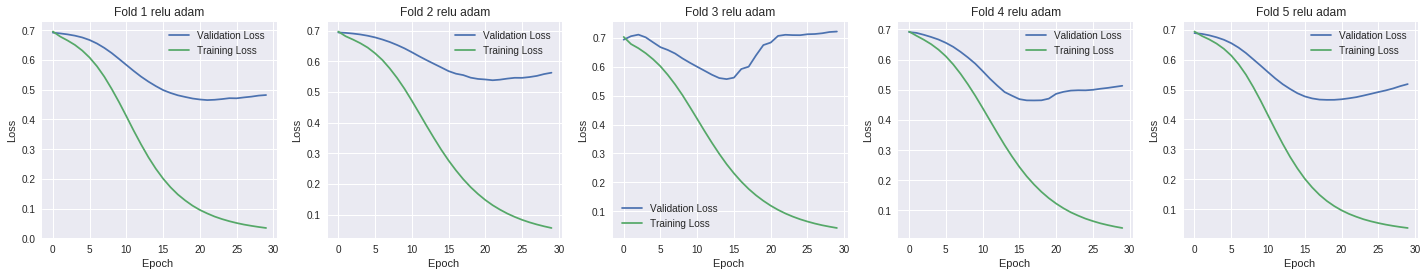

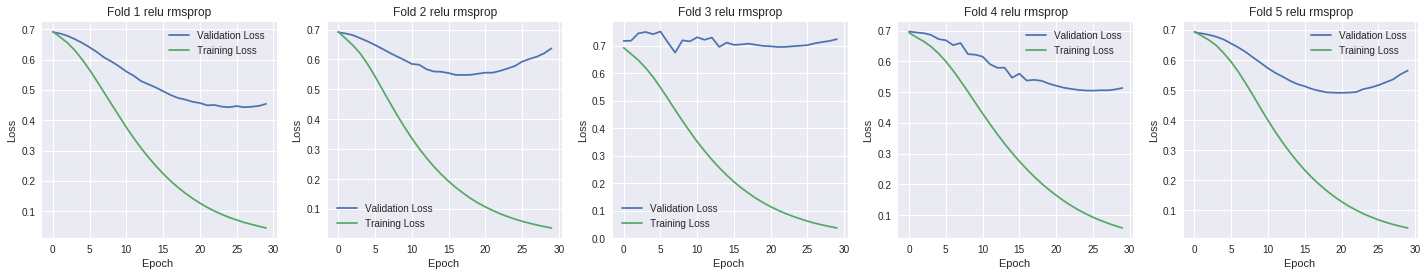

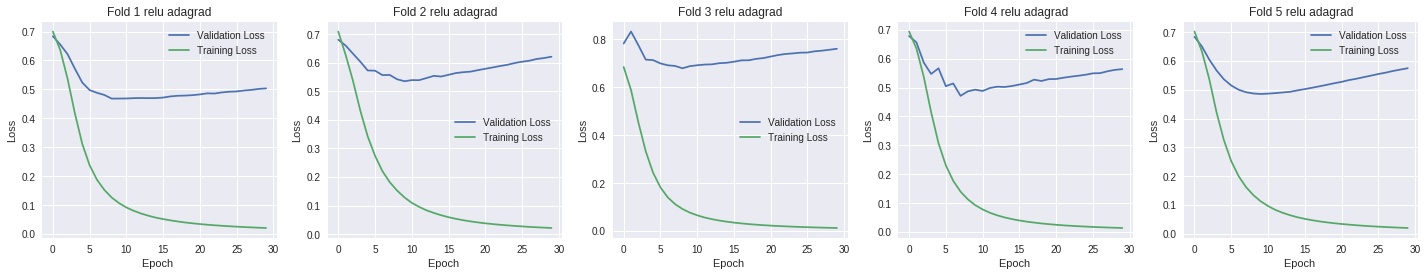

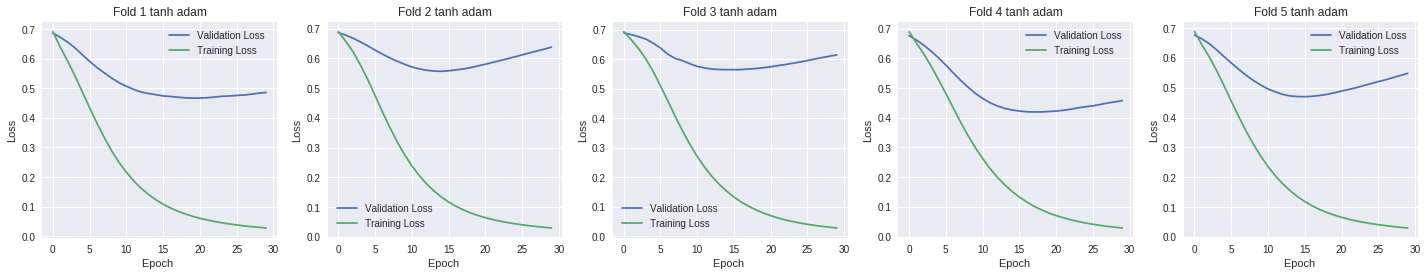

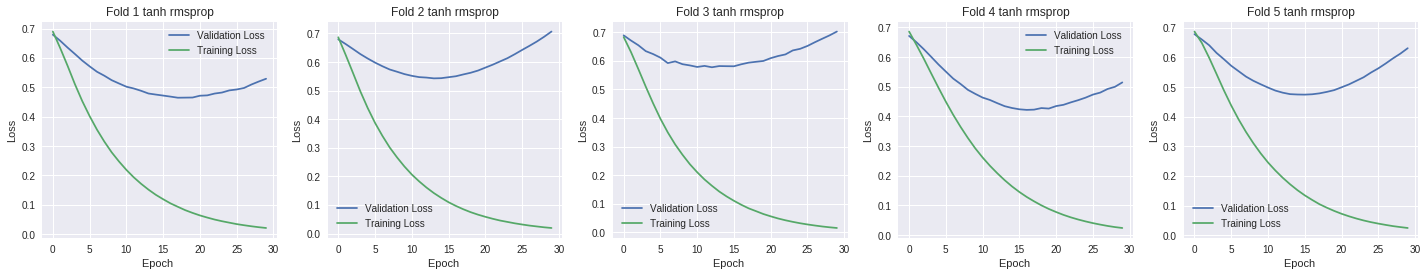

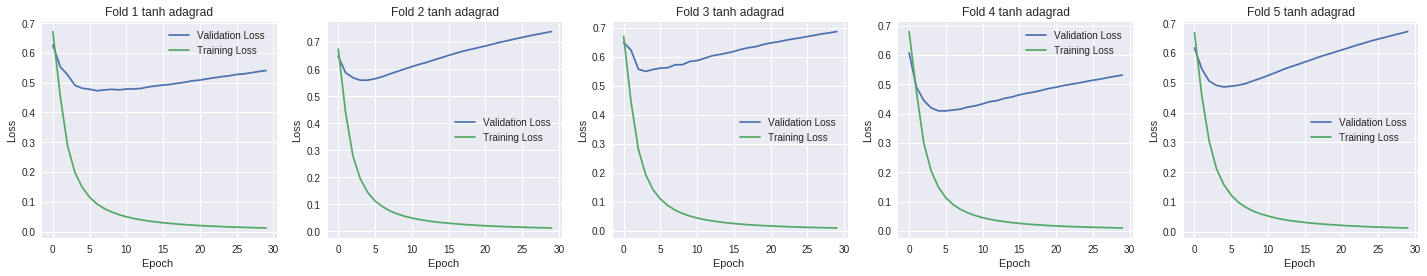

In [30]:
for activation, hists in all_hists.items():
  for optimizer, hist in hists.items():
    fig, ax = plt.subplots(nrows=1, ncols=5)
    #ax = [item for sublist in ax for item in sublist]
    for i, vals in enumerate(hist):
      ax[i].plot(vals["val_loss"], label="Validation Loss ")
      ax[i].plot(vals["loss"], label="Training Loss ")
      ax[i].set_ylabel("Loss")
      ax[i].set_xlabel("Epoch ")
      ax[i].set_title(" ".join(["Fold", str(i+1)])+" "+activation+" "+optimizer)
      ax[i].legend()
    fig.set_figheight(4)
    fig.set_figwidth(20)
    fig.tight_layout()
    plt.show()

### 1.4.2 Accuracy Plots

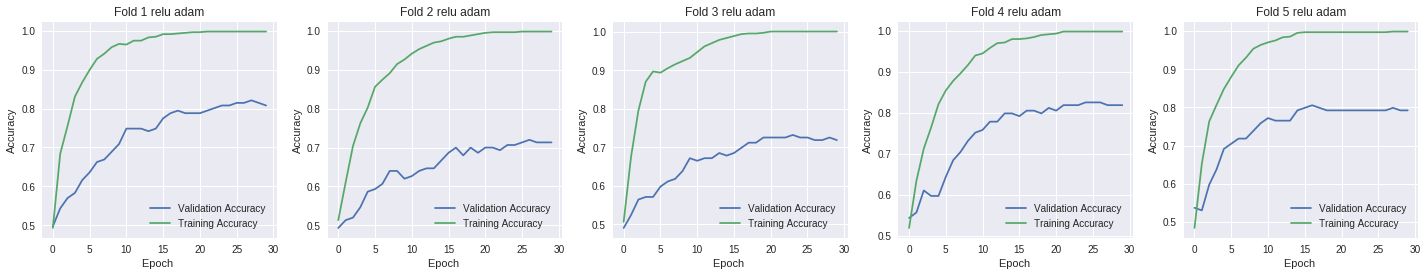

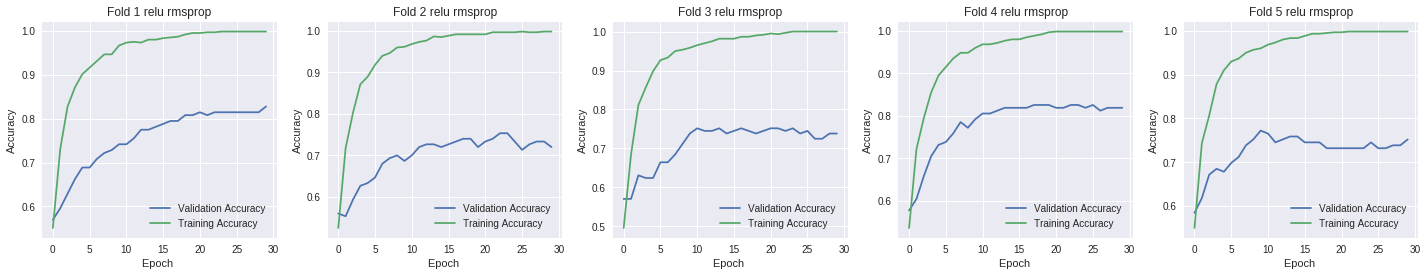

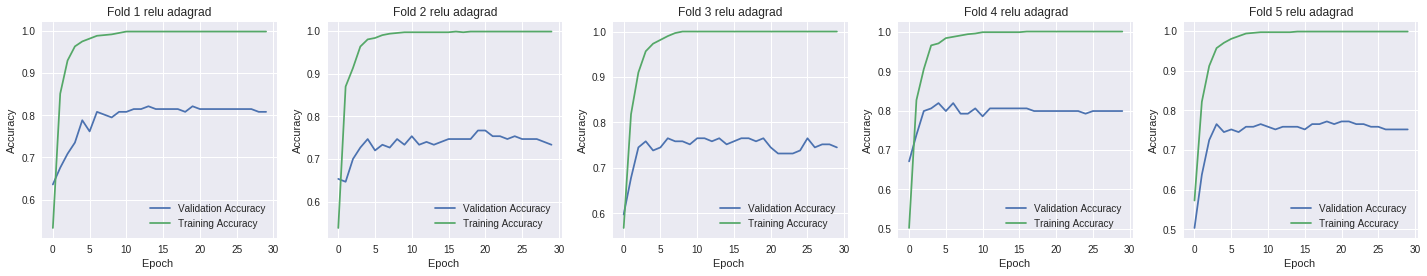

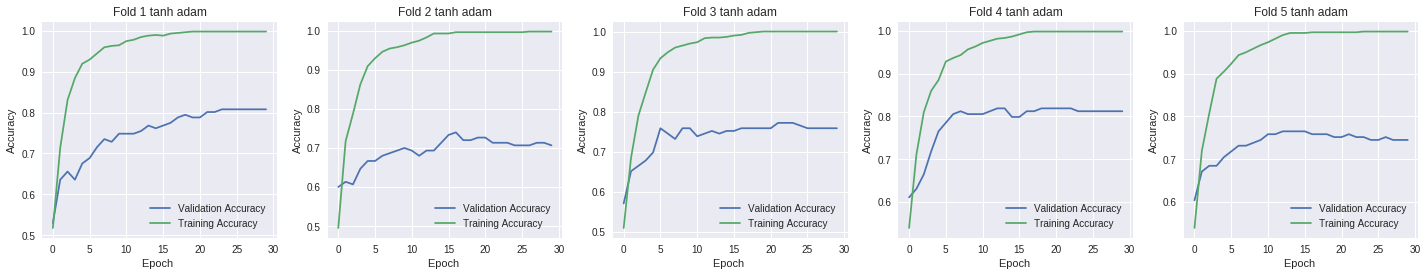

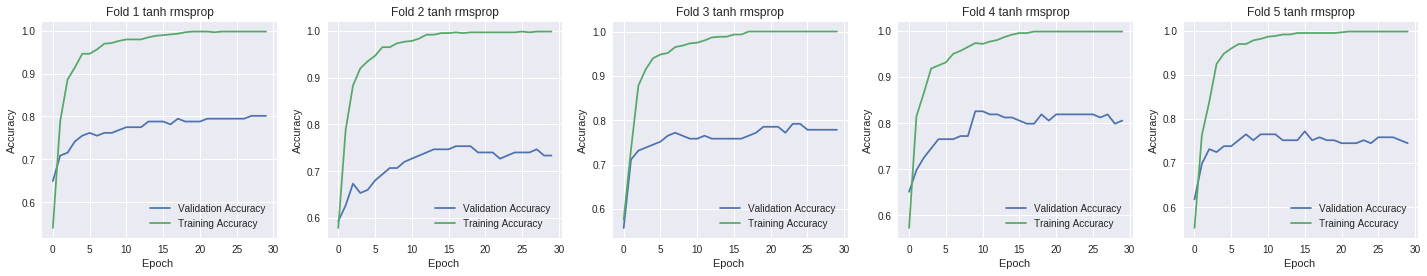

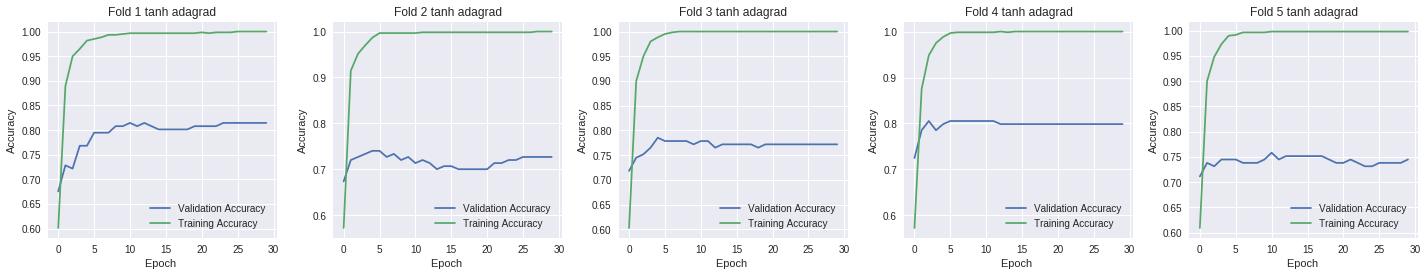

In [31]:
for activation, hists in all_hists.items():
  for optimizer, hist in hists.items():
    fig, ax = plt.subplots(nrows=1, ncols=5)
    #ax = [item for sublist in ax for item in sublist]
    for i, vals in enumerate(hist):
      ax[i].plot(vals["val_acc"], label="Validation Accuracy ")
      ax[i].plot(vals["acc"], label="Training Accuracy ")
      ax[i].set_ylabel("Accuracy")
      ax[i].set_xlabel("Epoch ")
      ax[i].set_title(" ".join(["Fold", str(i+1)])+" "+activation+" "+optimizer)
      ax[i].legend()
    fig.set_figheight(4)
    fig.set_figwidth(20)
    fig.tight_layout()
    plt.show()

### 1.4.3 Comments
<br>
On average, it seems that relu marginally outperforms tanh in this problem. <br>
Tanh generally converged faster than using relu. <br>
But to be honest, the dataset is really small for a deep learning task and make solid interpretations. <br>
Likewise, using the same hyperparameters, adam works better than adagrad and rmsprop for this case. <br>
Since there is not a large chunk of data, models with larger architectures overfit easily. Hence, 2 layers with 16 and 32 hidden layers was found to be the best performing. In the HW1-Hyperparameter Optimization file it can be seen that larger models have lower performance. <br>
On average, adagrad converges faster, but to a local minima most probably. Adam is actually an enhancement to adagrad as we know. <br>

Since the best performing model was found to be tanh and rmsprop for the particular choice of number of epochs and architecture, 2 layers with [16,32] units, I will stick with this model.

Although the validation loss increases, validation accuracy remains about the same. This might be a good example that early stopping with respect to validation loss might not always be a good idea. We could use other measures, such as Area under ROC curve to check model progress, to see how well the model distinguishes classes from each other.

# Question 2

## 2.1. Loading Reuters data, preparing folds

In [0]:
from keras.datasets import reuters
(data, labels), obj2 = reuters.load_data(num_words=10000, test_split=0)
n_classes = max(labels)+1
folds = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=1997).split(data, labels))

## 2.2. Model Function for Reuters experiments

In [0]:
def reuters_model(n_layers=2, n_hidden_units=[64,64], dropout=0.2, opt="adam", use_dropout=False, reg=None):
  if reg is None:
    regularizer = None
  elif reg=="l2":
    regularizer = regularizers.l2(0.01)
  elif reg=="l1":
    regularizer = regularizers.l1(0.01)
  model = Sequential()
  model.add(Dense(n_hidden_units[0], input_shape = (10000, ), kernel_regularizer=regularizer))
  model.add(Activation("relu"))
  if use_dropout:
    model.add(Dropout(rate = dropout))
  for i in range(1,n_layers):
    model.add(Dense(n_hidden_units[i], kernel_regularizer=regularizer))
    model.add(Activation("relu"))
    if use_dropout:
      model.add(Dropout(rate = dropout))
  model.add(Dense(n_classes))
  model.add(Activation("softmax"))
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

## 2.3. Training Phase

In [0]:
param_grid = {"reg":[None], "n_layers":[2,3,4], "n_hidden_units":[[64,64,64,64],[64,128,128,128],[128,128,256,256]]}

grid = ParameterGrid(param_grid)
best = -float("inf")
best_p = None
best_hist = None
all_scores = []
all_hists = dict()
all_hists[2] = dict()
all_hists[3] = dict()
all_hists[4] = dict()

for params in grid:
  print("Params: ",params)
  hist, scores = train(data, labels, folds, reuters_model, params,
                       "Tokenizer", True, None, verbose=0, max_epochs=15, batch_size=128)
  mean_ac = np.mean(np.array(scores)[:,1])
  all_scores.append(np.array(scores)[:,1])
  param_str = "/".join([str(i) for i in params["n_hidden_units"]])
  all_hists[params["n_layers"]][param_str]=[h.history for h in hist]
  
  if mean_ac>best:
    best = mean_ac
    best_p = params
    best_hist = hist
    print("Current Best: ")
    print("Params: ", params)
    print("Mean Accuracy: ",mean_ac)
  del hist

print("Best params: ", best_p)

Params:  {'n_hidden_units': [64, 64, 64, 64], 'n_layers': 2, 'reg': None}
Mean score:  0.8053743788184894
Current Best: 
Params:  {'n_hidden_units': [64, 64, 64, 64], 'n_layers': 2, 'reg': None}
Mean Accuracy:  0.8053743788184894
Params:  {'n_hidden_units': [64, 64, 64, 64], 'n_layers': 3, 'reg': None}
Mean score:  0.7976221987333659
Params:  {'n_hidden_units': [64, 64, 64, 64], 'n_layers': 4, 'reg': None}
Mean score:  0.7881305948709307
Params:  {'n_hidden_units': [64, 128, 128, 128], 'n_layers': 2, 'reg': None}
Mean score:  0.8037277371694808
Params:  {'n_hidden_units': [64, 128, 128, 128], 'n_layers': 3, 'reg': None}
Mean score:  0.8002204518161081
Params:  {'n_hidden_units': [64, 128, 128, 128], 'n_layers': 4, 'reg': None}
Mean score:  0.7925990811071729
Params:  {'n_hidden_units': [128, 128, 256, 256], 'n_layers': 2, 'reg': None}
Mean score:  0.8070622177319571
Current Best: 
Params:  {'n_hidden_units': [128, 128, 256, 256], 'n_layers': 2, 'reg': None}
Mean Accuracy:  0.8070622177

## 2.4. Results

### 2.4.1 Loss Plots 

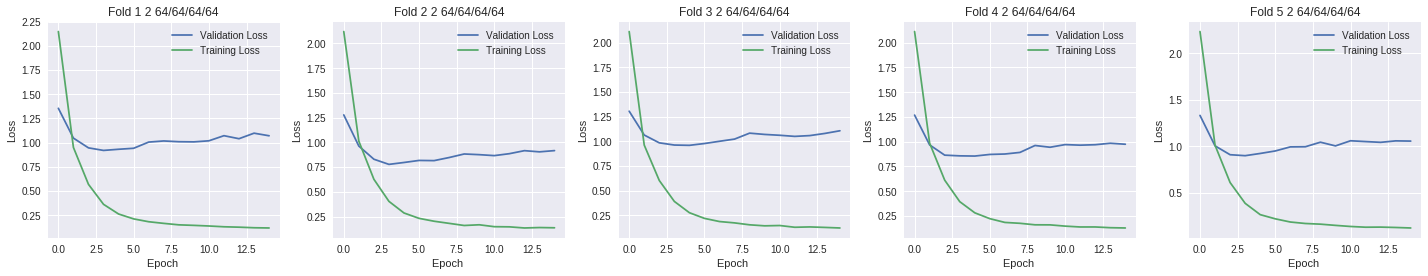

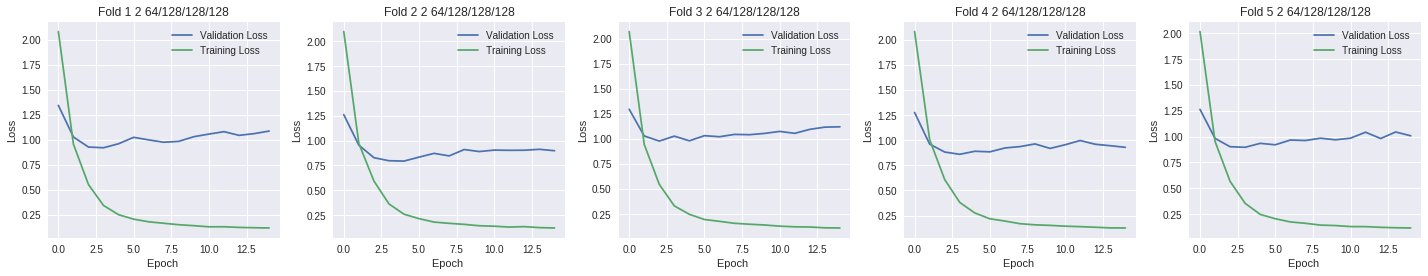

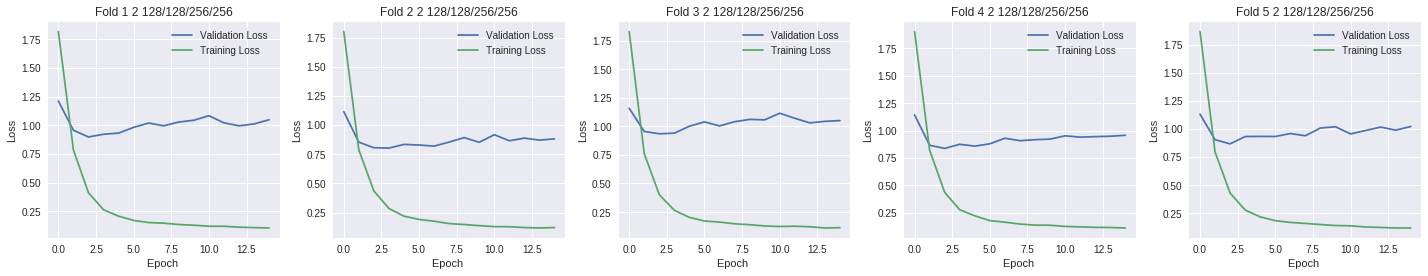

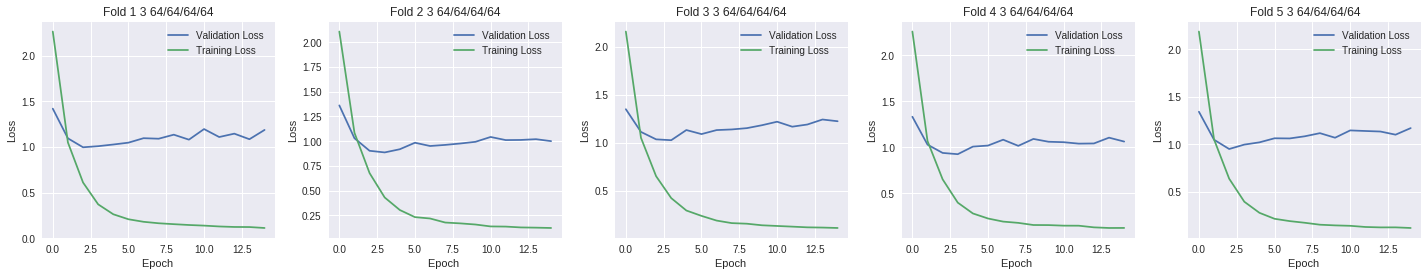

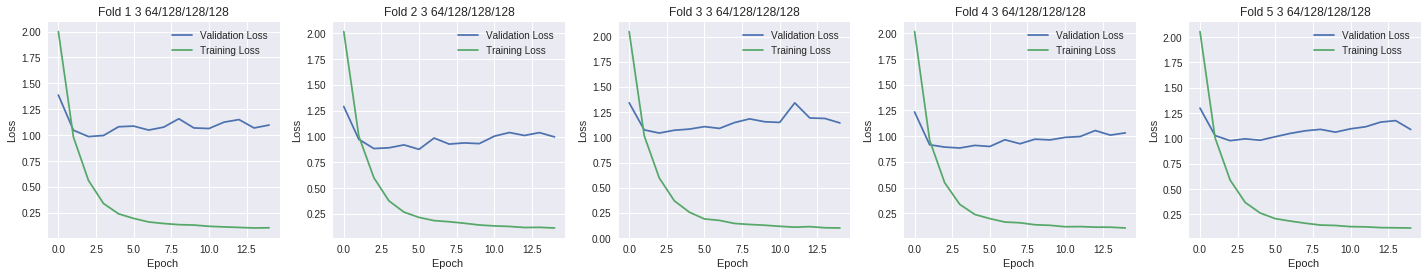

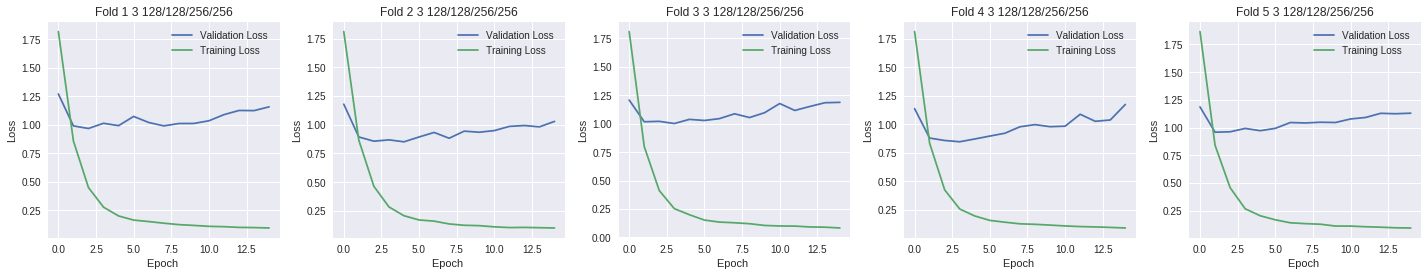

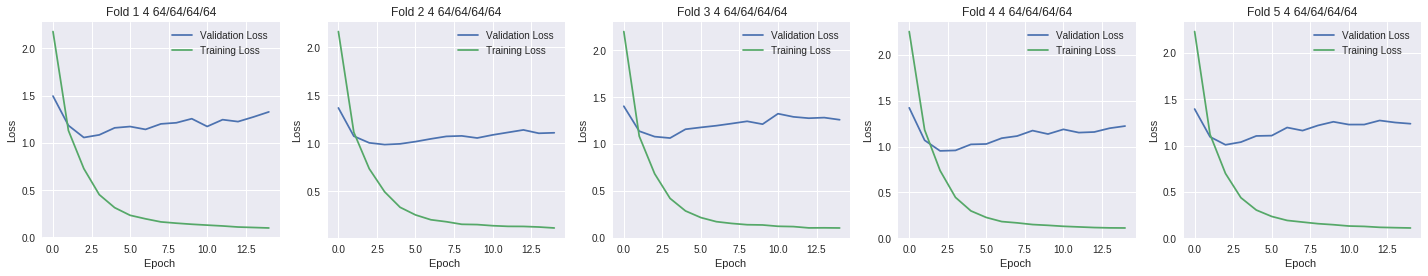

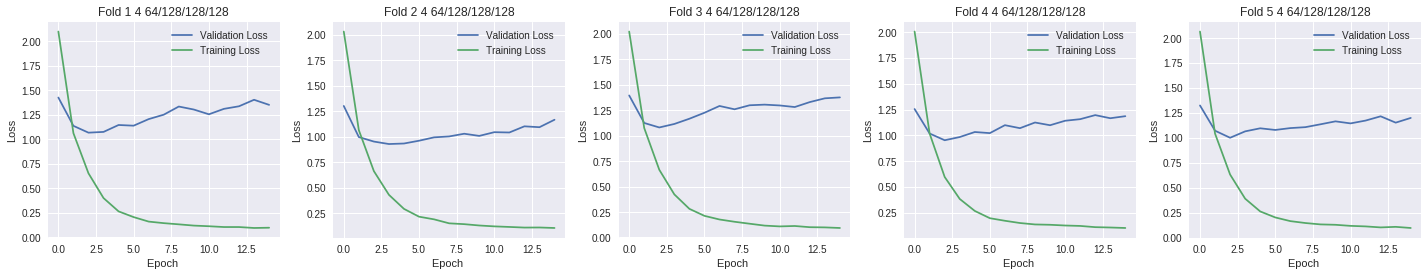

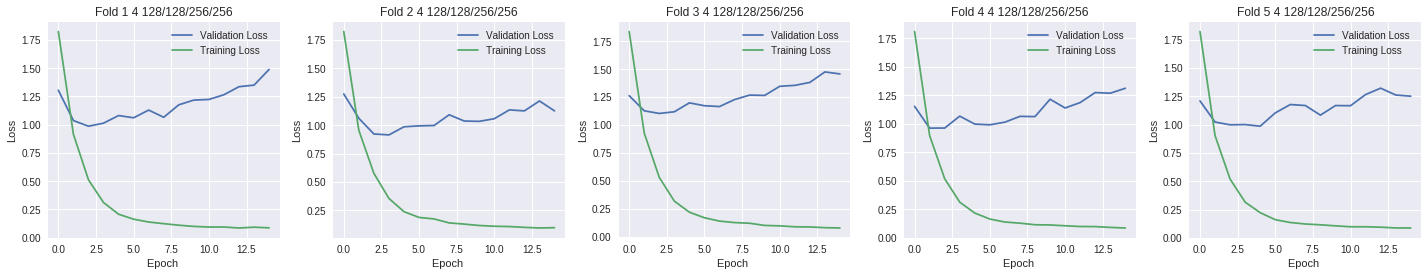

In [0]:
for n_layers, hists in all_hists.items():
  for n_hiddens, hist in hists.items():
    fig, ax = plt.subplots(nrows=1, ncols=5)
    #ax = [item for sublist in ax for item in sublist]
    for i, vals in enumerate(hist):
      ax[i].plot(vals["val_loss"], label="Validation Loss ")
      ax[i].plot(vals["loss"], label="Training Loss ")
      ax[i].set_ylabel("Loss")
      ax[i].set_xlabel("Epoch ")
      ax[i].set_title(" ".join(["Fold", str(i+1)])+" "+str(n_layers)+" "+n_hiddens)
      ax[i].legend()
    fig.set_figheight(4)
    fig.set_figwidth(20)
    fig.tight_layout()
    plt.show()

### 2.4.2 Accuracy Plots

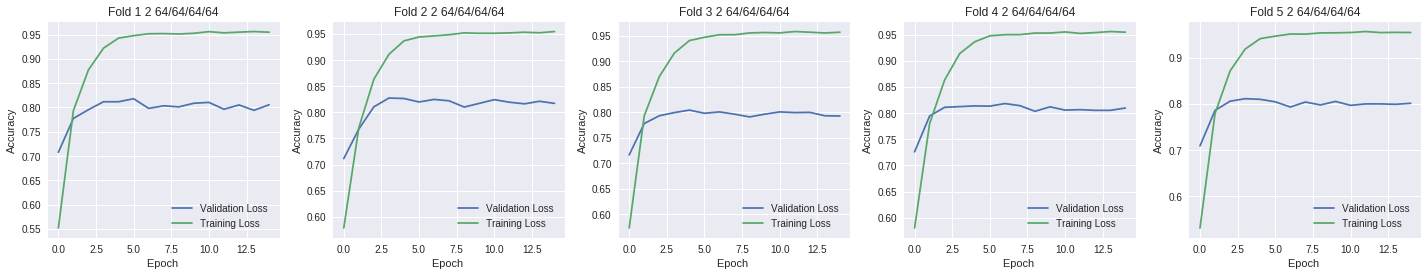

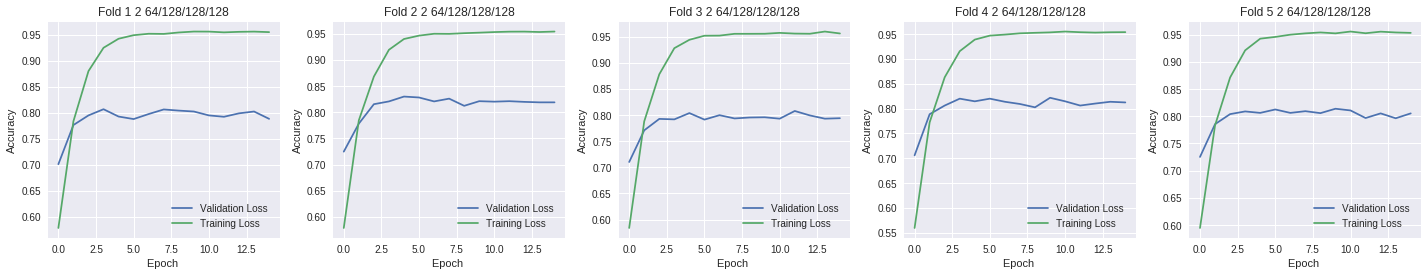

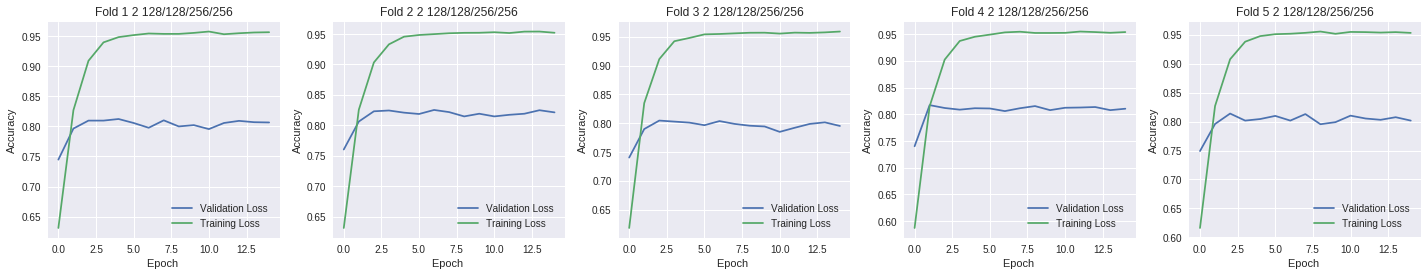

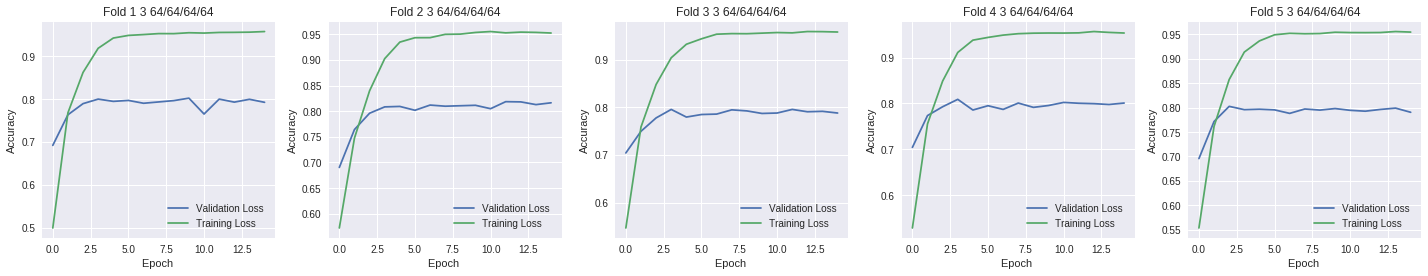

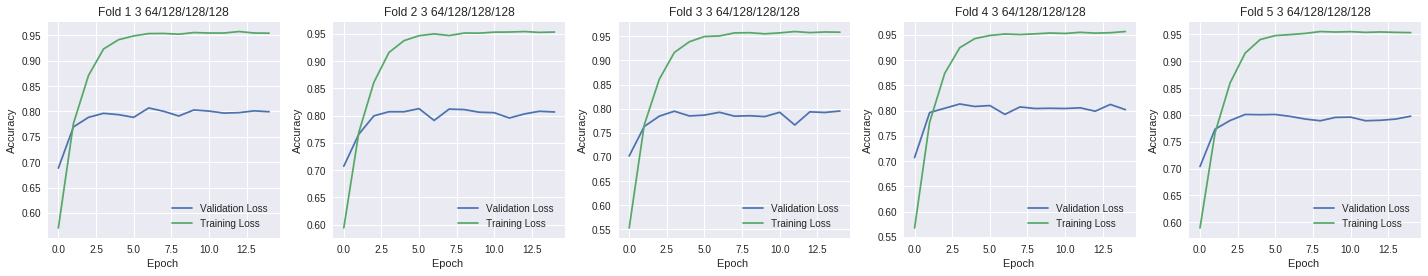

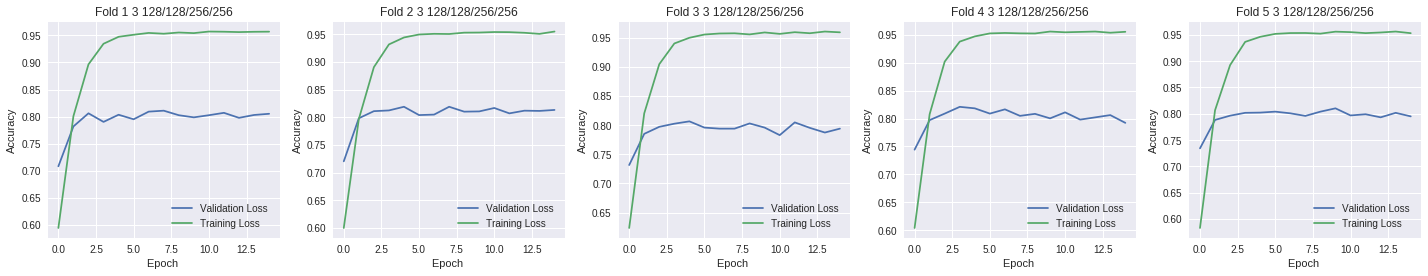

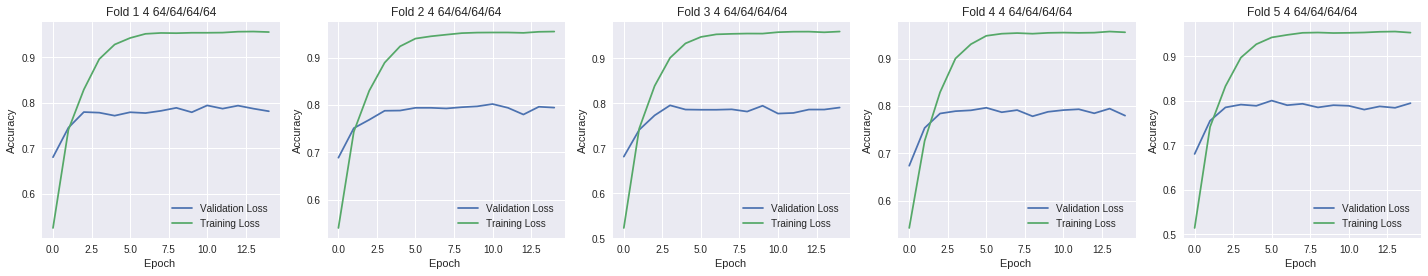

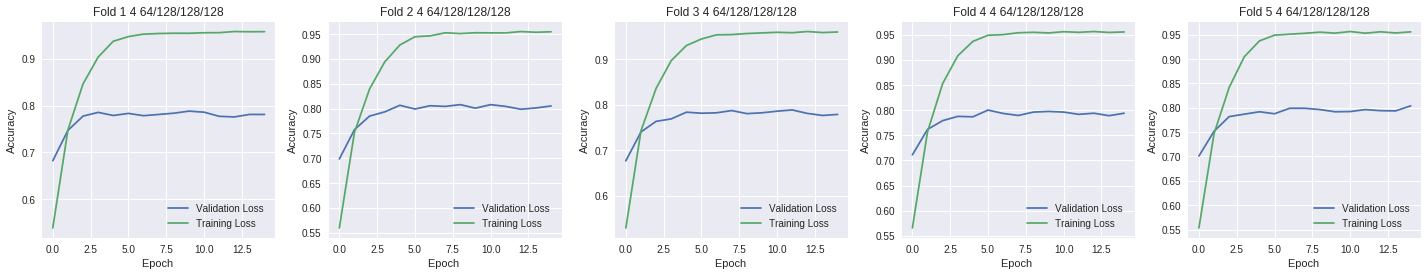

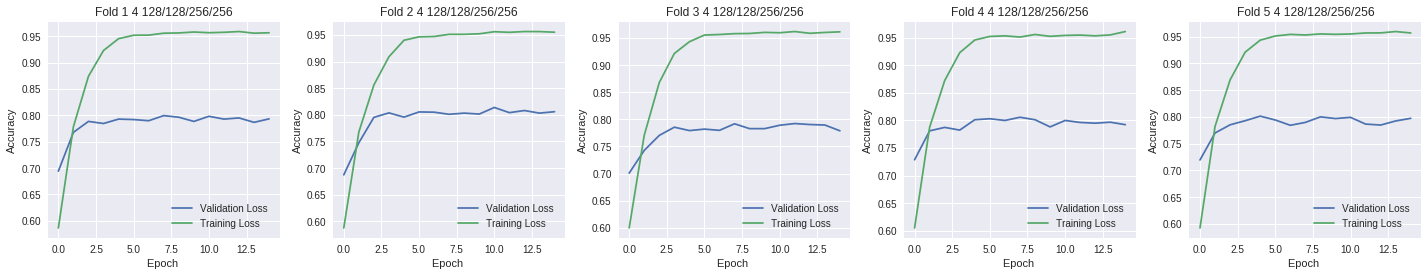

In [0]:
for n_layers, hists in all_hists.items():
  for n_hiddens, hist in hists.items():
    fig, ax = plt.subplots(nrows=1, ncols=5)
    #ax = [item for sublist in ax for item in sublist]
    for i, vals in enumerate(hist):
      ax[i].plot(vals["val_acc"], label="Validation Loss ")
      ax[i].plot(vals["acc"], label="Training Loss ")
      ax[i].set_ylabel("Accuracy")
      ax[i].set_xlabel("Epoch ")
      ax[i].set_title(" ".join(["Fold", str(i+1)])+" "+str(n_layers)+" "+n_hiddens)
      ax[i].legend()
    fig.set_figheight(4)
    fig.set_figwidth(20)
    fig.tight_layout()
    plt.show()

### 2.4.3 Comments

Since we have a medium size data, this architecture performs the best with medium size layers. The improvement is marginal, nothing so obvious, but on average 2 layers work better than 3 layers, and [128,128] works better than larger or smaller number of hidden units.  <br> 
It can be seen that higher number of layers display overfitting behaviour, increasing of validation loss, quicker. The same thing is true for increasing number of layers <br> Lesser number of units than [128,128] marginally underfits, cannot learn the underlying structure, displaying bias. <br>
If we decrease the numbers(can be found in HW1-Hyperparameter Experiments.ipynb) or increase the numbers performance marginally drops. <br>
Since it is the highest performance w.r.t accuracy and validation loss, I will stick with [128,128] and 2 layers. Other hyperparameters are controlled variable, where we don't utilize any regularization and use adam as optimizer.

# Question 3

## 3.1 Loading Boston-Housing Data

In [0]:
from keras.datasets import boston_housing
(data, target), _ = boston_housing.load_data(test_split=0)
folds = list(KFold(n_splits=5, shuffle=True, random_state=1997).split(data, target))

57344/57026 [==============================] - 0s 2us/step


## 3.2 Model Function for Regression

In [0]:
def boston_model(n_layers=2, n_hidden_units=[64,128], reg=None, use_dropout=True, opt="adam", Loss="mse"):
  if reg is None:
    regularizer = None
  if reg == "l2":
    regularizer = regularizers.l2(0.01)
  elif reg == "l1":
    regularizer = regularizers.l1(0.01)
  model = Sequential()
  model.add(Dense(n_hidden_units[0], input_shape = (13, ), kernel_regularizer=regularizer))
  model.add(Activation("relu"))
  if use_dropout:
    model.add(Dropout(rate=0.2))
  for i in range(n_layers-1):
    model.add(Dense(n_hidden_units[i+1], kernel_regularizer=regularizer))
    model.add(Activation("relu"))
    if use_dropout:
      model.add(Dropout(rate=0.2))
  model.add(Dense(1))
  model.compile(loss=Loss, optimizer=opt, metrics=['mae'])
  return model

## 3.3 Training Phase

In [0]:
param_grid = {"Loss": ["mae", "mse"], "reg":[None, "l2"],
              "use_dropout":[True, False], "n_layers":[3], "n_hidden_units":[[64,64, 64]]}

grid = ParameterGrid(param_grid)
best = float("inf")
best_p = None
best_hist = None
all_scores = []
all_hists = dict()
all_hists["mse"] = dict()
all_hists["mae"] = dict()

for params in grid:
  print("Params: ",params)
  hist, scores = train(data, target, folds, boston_model, params,
                       "Normalize", False, None, verbose=0, max_epochs=500, batch_size=128)
  mean_mae = np.mean(np.array(scores)[:,1])
  all_scores.append(np.array(scores)[:,1])
  param_str = "/".join([str(params["reg"]),str(params["use_dropout"])])
  all_hists[str(params["Loss"])][param_str]=[h.history for h in hist]
  
  if mean_mae<best:
    best = mean_mae
    best_p = params
    best_hist = hist
    print("Current Best: ")
    print("Params: ", params)
    print("Mean MAE Loss: ",mean_mae)
  del hist

print("Best params: ", best_p)

Params:  {'Loss': 'mae', 'n_hidden_units': [64, 64, 64], 'n_layers': 3, 'reg': None, 'use_dropout': True}
Mean score:  2.3888748313449835
Current Best: 
Params:  {'Loss': 'mae', 'n_hidden_units': [64, 64, 64], 'n_layers': 3, 'reg': None, 'use_dropout': True}
Mean MAE Loss:  2.3888748313449835
Params:  {'Loss': 'mae', 'n_hidden_units': [64, 64, 64], 'n_layers': 3, 'reg': None, 'use_dropout': False}
Mean score:  2.2473597790518682
Current Best: 
Params:  {'Loss': 'mae', 'n_hidden_units': [64, 64, 64], 'n_layers': 3, 'reg': None, 'use_dropout': False}
Mean MAE Loss:  2.2473597790518682
Params:  {'Loss': 'mae', 'n_hidden_units': [64, 64, 64], 'n_layers': 3, 'reg': 'l2', 'use_dropout': True}
Mean score:  2.352029277199427
Params:  {'Loss': 'mae', 'n_hidden_units': [64, 64, 64], 'n_layers': 3, 'reg': 'l2', 'use_dropout': False}
Mean score:  2.2796520569374943
Params:  {'Loss': 'mse', 'n_hidden_units': [64, 64, 64], 'n_layers': 3, 'reg': None, 'use_dropout': True}
Mean score:  2.3521428257348

## 3.4 Results

### 3.4.1 MAE Plots

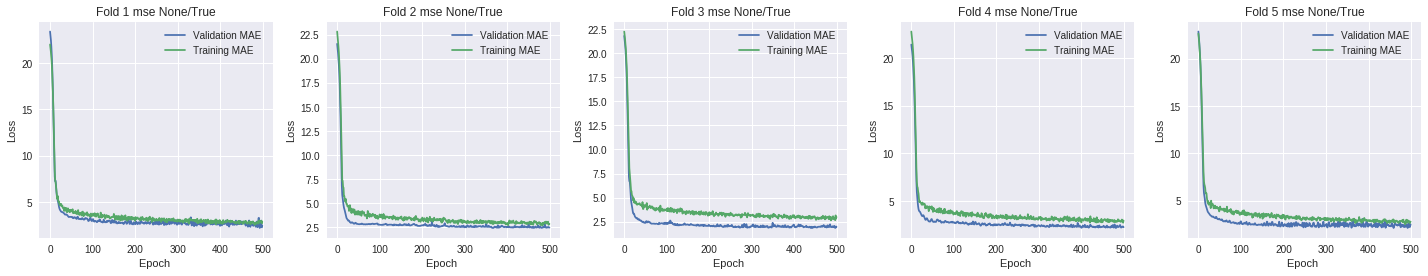

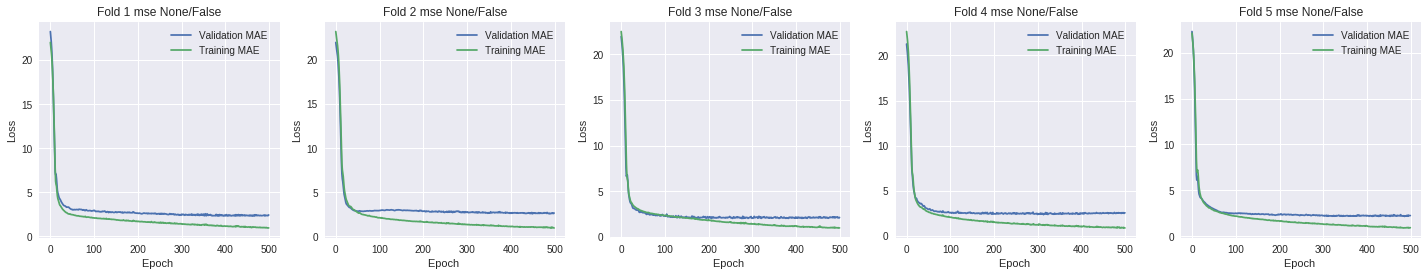

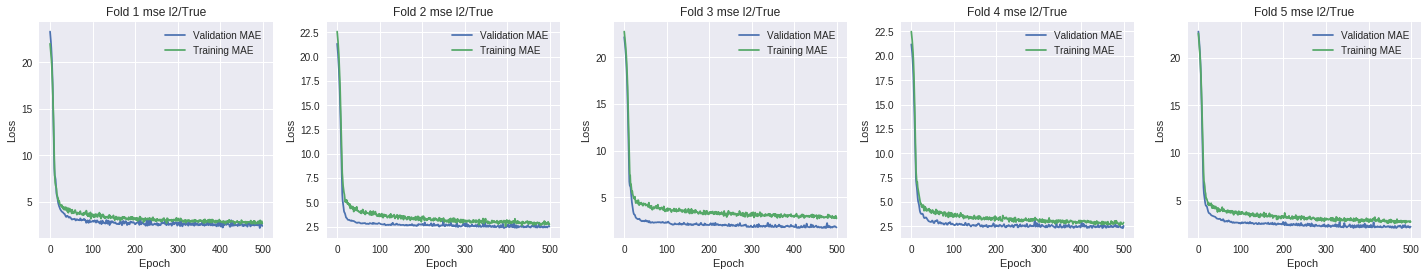

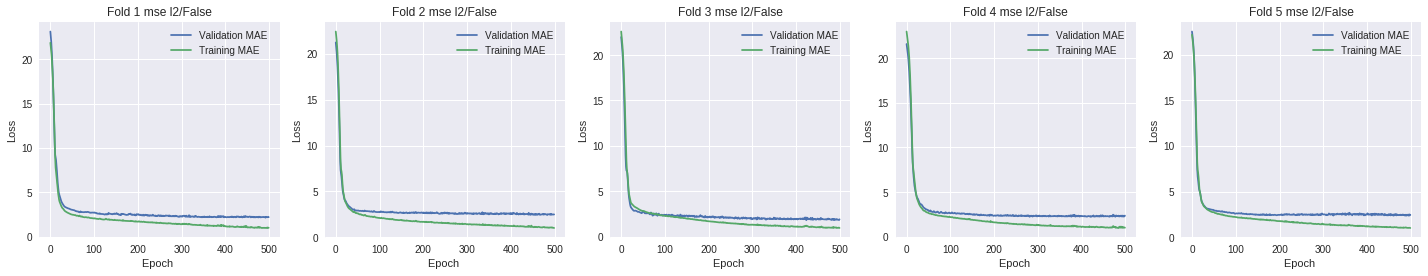

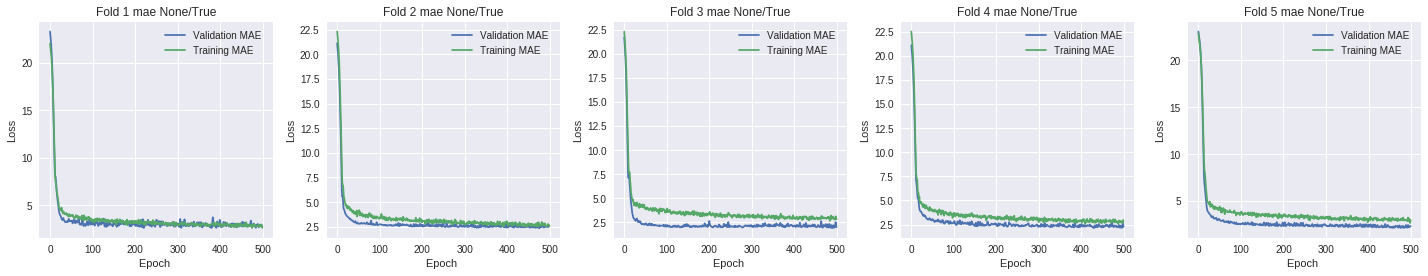

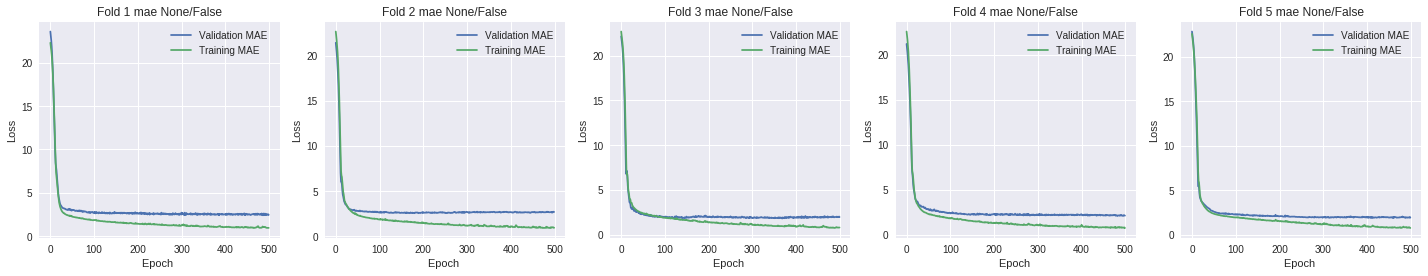

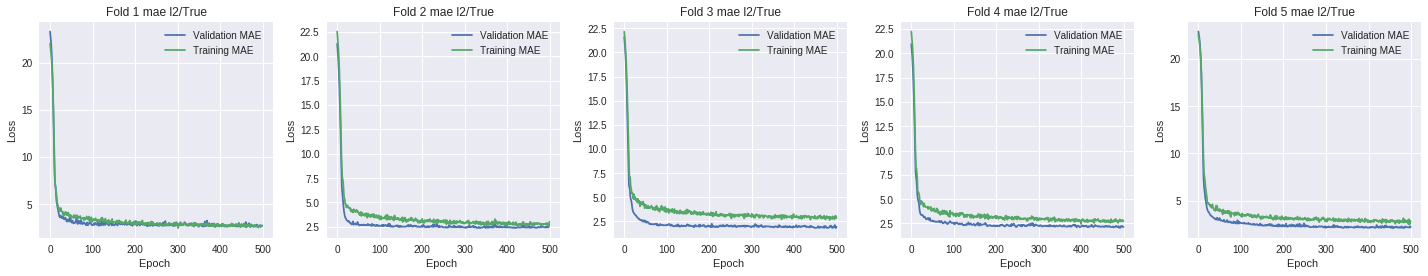

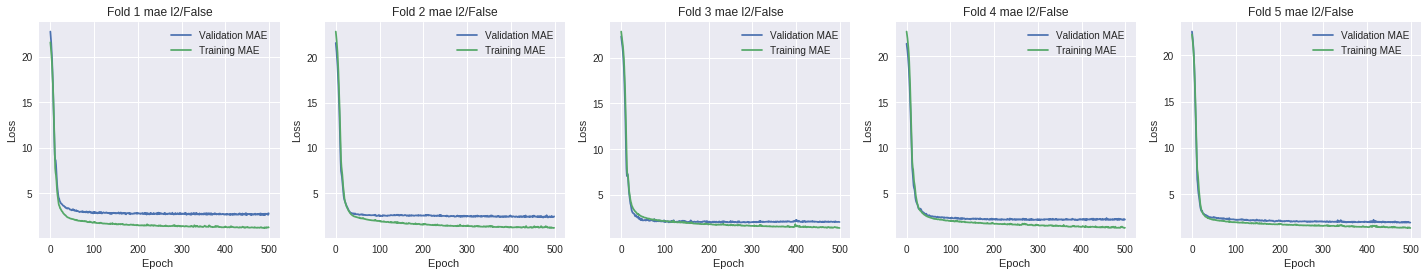

In [0]:
for loss, hists in all_hists.items():
  for params, hist in hists.items():
    fig, ax = plt.subplots(nrows=1, ncols=5)
    #ax = [item for sublist in ax for item in sublist]
    for i, vals in enumerate(hist):
      ax[i].plot(vals["val_mean_absolute_error"], label="Validation MAE ")
      ax[i].plot(vals["mean_absolute_error"], label="Training MAE ")
      ax[i].set_ylabel("Loss")
      ax[i].set_xlabel("Epoch ")
      ax[i].set_title(" ".join(["Fold", str(i+1)])+" "+loss+" "+params)
      ax[i].legend()
    fig.set_figheight(4)
    fig.set_figwidth(20)
    fig.tight_layout()
    plt.show()

### 3.4.2 Comments
As can be seen from the logs, regularization does not play well in this architecture. As the size of data is small, the model is heavily dependent on the choice of training and test datasets. Using regularization increases the MAE loss on average. This is probably because there is already a little we can learn from the data, and regularizing inhibits the learning process and we already cannot over-learn features. <br>
When we look at the loss plots, we can see that using regularization increases noise in the training phase. This is actually expected, as we stated above due to the small size of the data and regularization's nature. <br>
Tje best case arises using MAE with no regularization. This would actually suggest using a higher number of layers with regularization might perform well. But for this particular choice of architecture size, using no regularization performs the best. Hence, I will stick with this.